In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

## Global params

In [2]:
data_dir = './gtsrb-german-traffic-sign'
train_path = './gtsrb-german-traffic-sign/Train'
test_path = './gtsrb-german-traffic-sign/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [3]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [4]:
# Labels map
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Data visualization

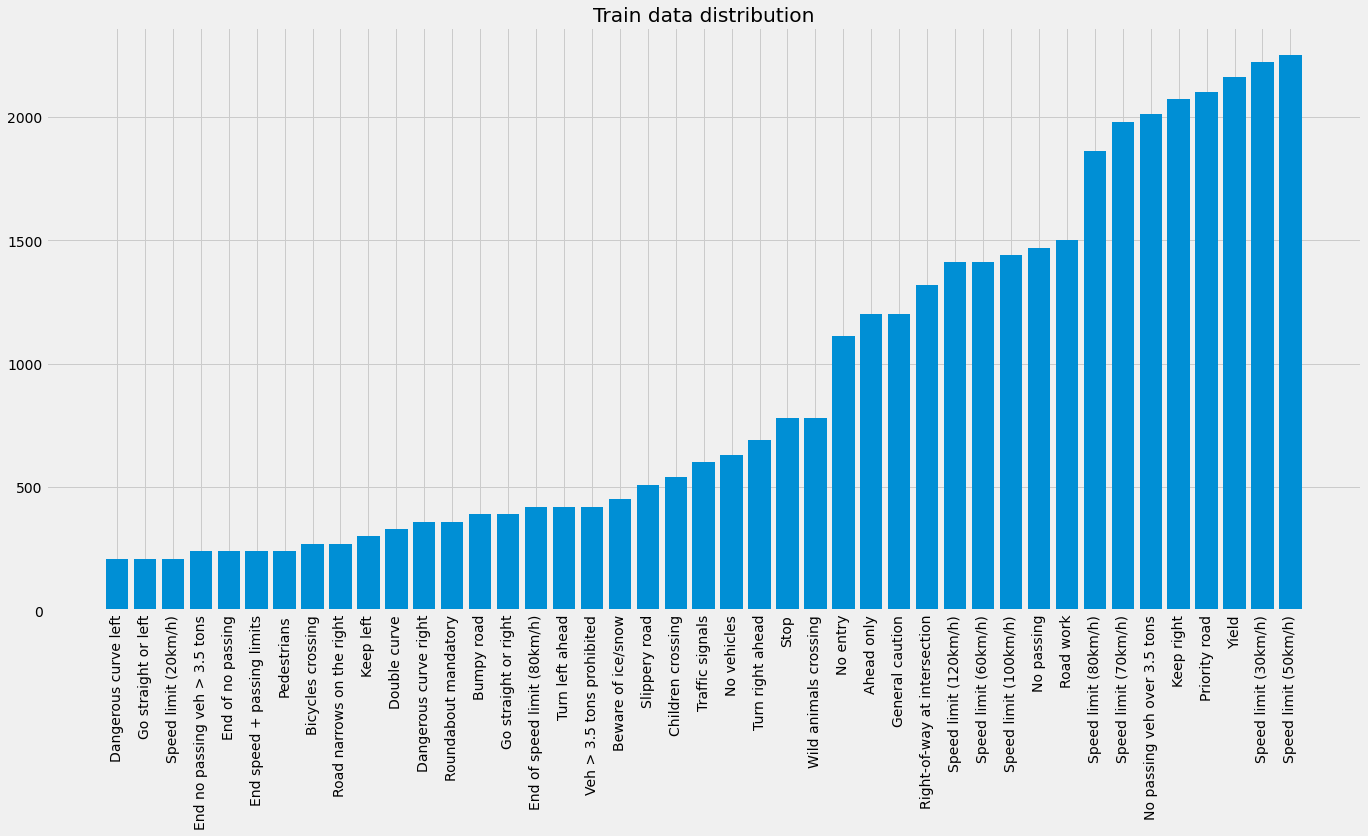

In [5]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.title('Train data distribution')
plt.show()

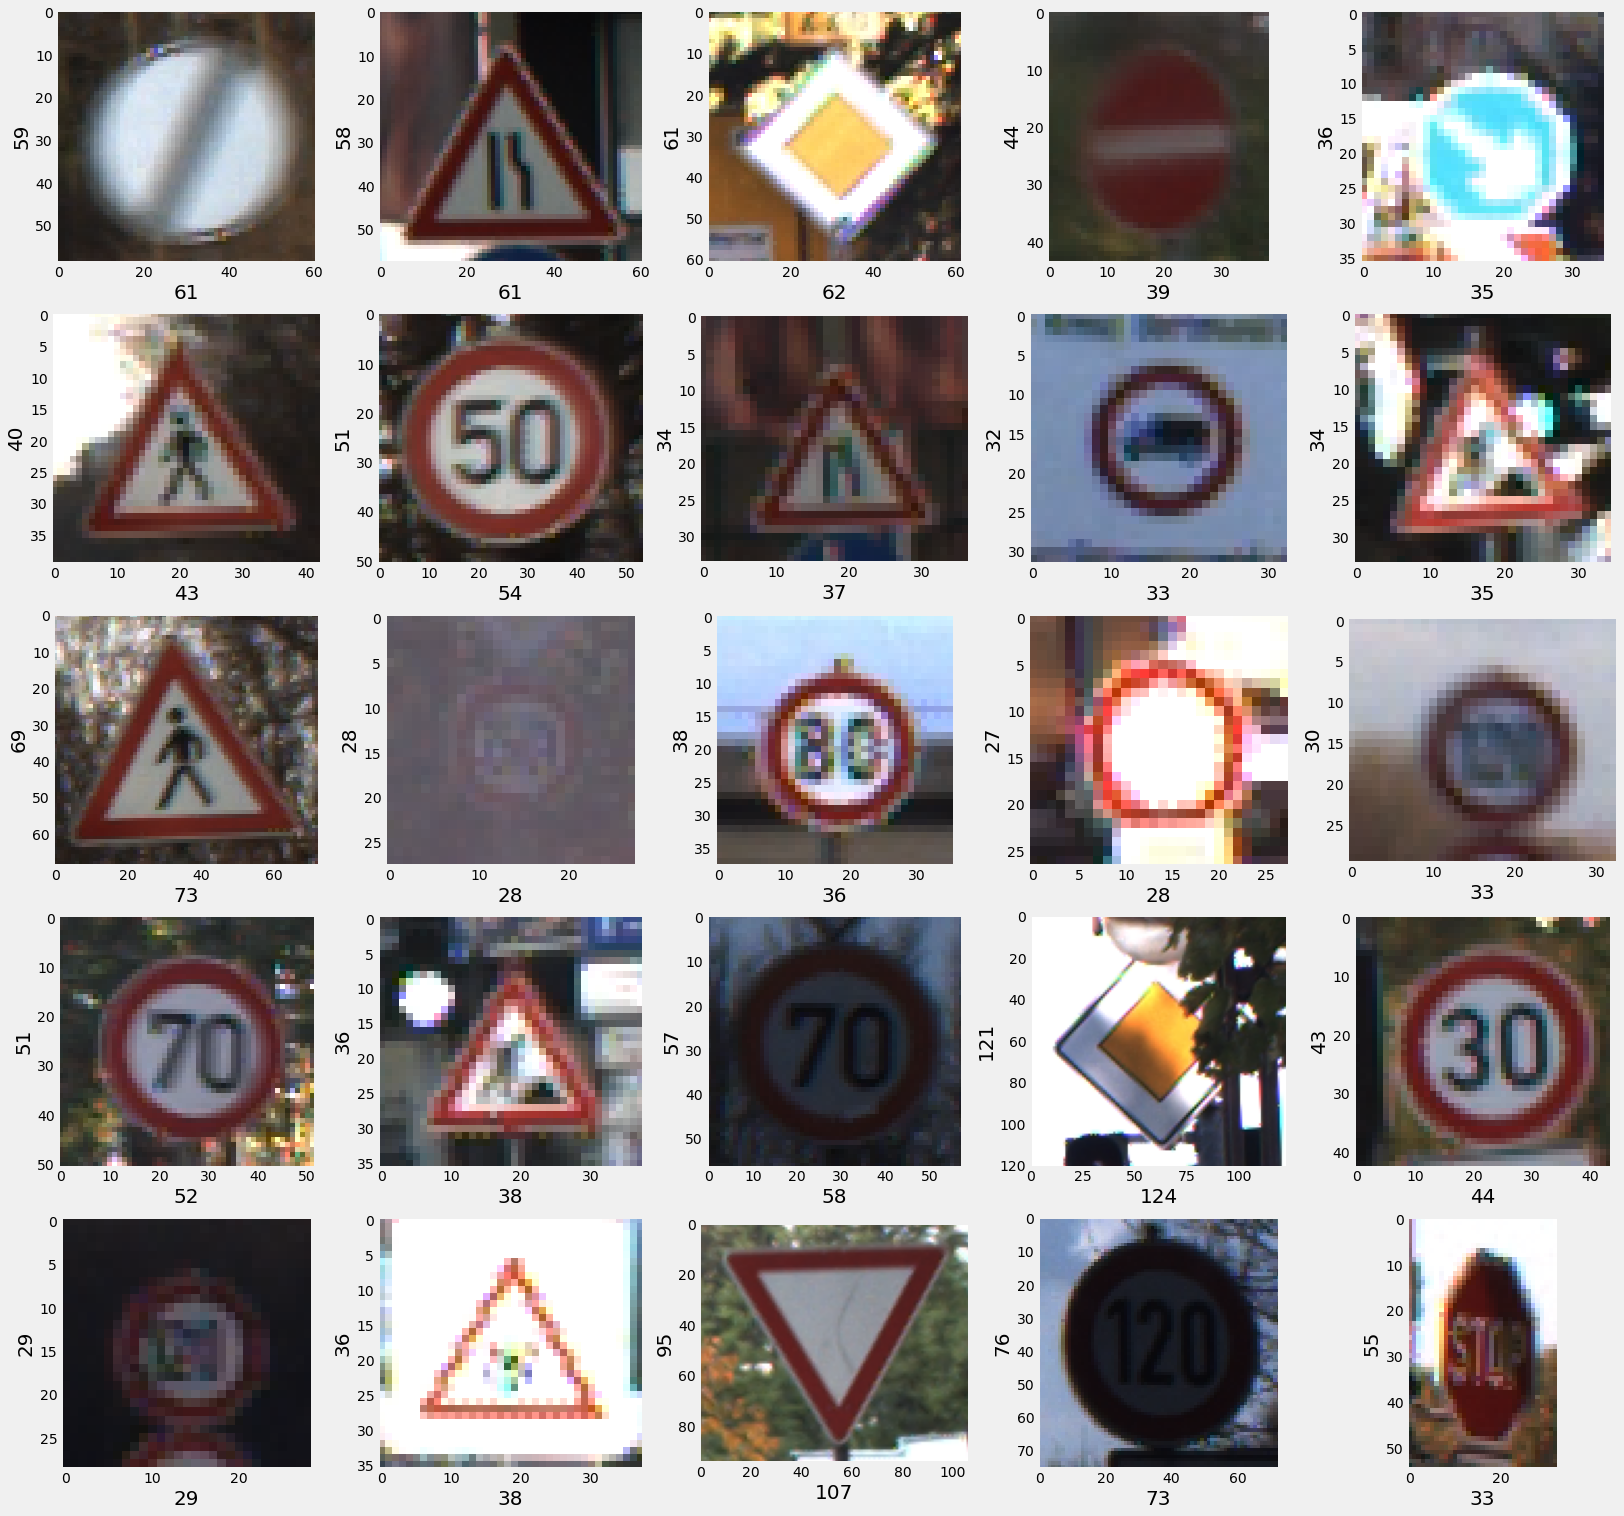

In [6]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## Image processing

In [7]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## Data split into train/test

In [8]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)

image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [9]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, 
                                                  test_size=0.3, 
                                                  random_state=42, shuffle=True)

X_train = X_train / 255 
X_val = X_val / 255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [10]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


## Model building

In [11]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:
lr = 0.001
epochs = 30

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Model training

In [13]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 33s 39ms/step - loss: 1.0153 - acc: 0.7233 - val_loss: 0.1221 - val_acc: 0.9599
Epoch 2/30
858/858 [==============================] - 30s 35ms/step - loss: 0.1799 - acc: 0.9455 - val_loss: 0.0666 - val_acc: 0.9801
Epoch 3/30
858/858 [==============================] - 30s 35ms/step - loss: 0.1085 - acc: 0.9666 - val_loss: 0.0502 - val_acc: 0.9859
Epoch 4/30
858/858 [==============================] - 31s 36ms/step - loss: 0.0815 - acc: 0.9749 - val_loss: 0.0248 - val_acc: 0.9906
Epoch 5/30
858/858 [==============================] - 31s 36ms/step - loss: 0.0646 - acc: 0.9801 - val_loss: 0.0128 - val_acc: 0.9955
Epoch 6/30
858/858 [==============================] - 31s 37ms/step - loss: 0.0559 - acc: 0.9831 - val_loss: 0.0113 - val_acc: 0.9966
Epoch 7/30
858/858 [==============================] - 31s 36ms/step - loss: 0.0478 - acc: 0.9853 - val_loss: 0.0139 - val_acc: 0.9959
Epoch 8/30
858/858 [==============================] - 31s 36ms

858/858 [==============================] - 31s 37ms/step - loss: 0.0212 - acc: 0.9936 - val_loss: 0.0051 - val_acc: 0.9980
Epoch 13/30
858/858 [==============================] - 31s 36ms/step - loss: 0.0240 - acc: 0.9922 - val_loss: 0.0077 - val_acc: 0.9979
Epoch 14/30
858/858 [==============================] - 32s 37ms/step - loss: 0.0257 - acc: 0.9926 - val_loss: 0.0108 - val_acc: 0.9969
Epoch 15/30
858/858 [==============================] - 31s 36ms/step - loss: 0.0185 - acc: 0.9936 - val_loss: 0.0022 - val_acc: 0.9994
Epoch 16/30
858/858 [==============================] - 32s 37ms/step - loss: 0.0151 - acc: 0.9949 - val_loss: 0.0100 - val_acc: 0.9969
Epoch 17/30
858/858 [==============================] - 34s 40ms/step - loss: 0.0217 - acc: 0.9934 - val_loss: 0.0155 - val_acc: 0.9956
Epoch 18/30
858/858 [==============================] - 35s 41ms/step - loss: 0.0183 - acc: 0.9937 - val_loss: 0.0038 - val_acc: 0.9990
Epoch 19/30
858/858 [==============================] - 39s 46ms/ste

858/858 [==============================] - 42s 48ms/step - loss: 0.0098 - acc: 0.9970 - val_loss: 0.0037 - val_acc: 0.9986
Epoch 25/30
858/858 [==============================] - 41s 48ms/step - loss: 0.0113 - acc: 0.9966 - val_loss: 0.0037 - val_acc: 0.9990
Epoch 26/30
858/858 [==============================] - 41s 48ms/step - loss: 0.0123 - acc: 0.9963 - val_loss: 0.0052 - val_acc: 0.9992
Epoch 27/30
858/858 [==============================] - 36s 42ms/step - loss: 0.0106 - acc: 0.9966 - val_loss: 0.0030 - val_acc: 0.9991
Epoch 28/30
858/858 [==============================] - 33s 39ms/step - loss: 0.0090 - acc: 0.9972 - val_loss: 0.0028 - val_acc: 0.9989
Epoch 29/30
858/858 [==============================] - 34s 40ms/step - loss: 0.0113 - acc: 0.9969 - val_loss: 0.0018 - val_acc: 0.9993
Epoch 30/30
858/858 [==============================] - 39s 45ms/step - loss: 0.0080 - acc: 0.9976 - val_loss: 0.0018 - val_acc: 0.9996


In [14]:
model.save('./trained_model/classification_model.h5', save_format='h5')

In [26]:
from tensorflow import keras
model = keras.models.load_model('./trained_model/classification_model.h5')

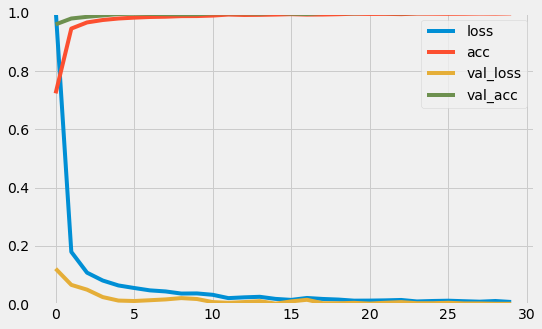

In [27]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [28]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data = []

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = model.predict_classes(X_test)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  98.91528107680126


Text(0.5, 1.0, 'Speed limit (20km/h)')

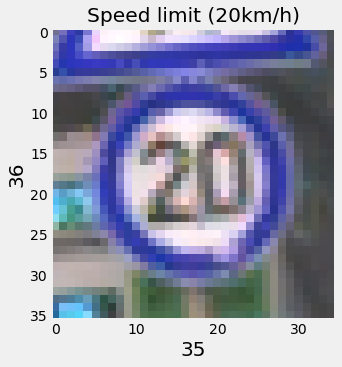

In [29]:
data = []
try:
    image = cv2.imread('./gtsrb-german-traffic-sign/train/0/00000_00000_00010.png')
    image_fromarray = Image.fromarray(image, 'RGB')
    resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
    data.append(np.array(resize_image))
except:
    print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = model.predict_classes(X_test)

plt.figure(figsize=(5,5))

rand_img = image
plt.imshow(rand_img)
plt.grid(b=None)
plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image
plt.title(f'{classes[pred[0]]}')

In [30]:
model.predict(X_test)[0]

array([1.00000000e+00, 1.35985780e-16, 9.44125029e-19, 4.46248000e-15,
       9.21310452e-15, 4.91764433e-17, 4.54968465e-20, 4.87179038e-23,
       5.62095140e-16, 5.39800167e-20, 6.79559446e-16, 1.12718232e-14,
       4.72075562e-20, 2.23510736e-18, 5.09595701e-17, 4.22944475e-21,
       1.00382530e-16, 1.70313893e-18, 5.85887768e-18, 4.37796423e-18,
       1.05237665e-17, 2.75485021e-22, 2.48597360e-21, 3.68597041e-17,
       2.56810195e-18, 2.31405865e-18, 1.21929359e-17, 2.05674572e-18,
       1.37421343e-17, 7.20031794e-22, 3.64395355e-20, 1.81981488e-17,
       1.93628158e-17, 6.47203854e-18, 1.86955495e-18, 3.61325561e-18,
       4.37160404e-19, 7.30121225e-16, 4.90948334e-20, 2.07742779e-19,
       3.03607234e-16, 7.96429760e-18, 2.94969629e-17], dtype=float32)